## Calibração de intrísicos usando chessboard

- Utiliza a biblioteca OpenCV para obter a matriz de intrísicos da câmera
- Para obtê-la, fazemos uma comparação com distâncias entre pontos conhecidas no mundo real e as distâncias entre pontos no plano da imagem
- É escolhido um plano de calibração no qual conhecemos as distâncias entre os pontos, como por exemplo entre os cantos dos quadrados de um tabuleiro de xadrez

- Para realizar a calibração, é preciso tirar fotos do plano em diferentes poses
- Algumas boas práticas são:
    - Escolha um ambiente iluminado e, se possível, utilize uma fonte luminosa atrás da câmera
    - Prepare um dataset com várias imagens, assim você pode escolher as melhores para realizar a calibração
    - O plano de calibração precisa cobrir a maior parte das fotos, por isso se atente no tamanho do plano que você está utilizando

### Passo a passo da calibração
- Antes de tirar as fotos você precisa de um plano de calibração 
    - Para criar o seu, use o [código](https://docs.opencv.org/4.x/da/d0d/tutorial_camera_calibration_pattern.html) disponibilizado pelo próprio OpenCV
- As imagens utilizadas na calibração precisam estar em escala de cinza!
    - Antes de analisar as imagens, converta-as para grayscale 

- Para encontrar os cantos dos quadrados do tabuleiro, são usadas duas abordagens:
    - A primeira utiliza um método que determina o canto do quadrado no ponto em que o branco se torna preto na imagem, pela função `findChessboardCorners()`. Os cantos encontrados não são tão exatos, por isso passam por um refinamento pela função `cornerSubPix()`
    - A segunda utiliza uma abordagem diferente, na qual usa a função `findChessboardCornersSB()`

### Importação das bibliotecas e informações sobre o padrão de calibração

A depender do padrão que escolher, você deverá mudar:
- patternSize (colunas X linhas)
- squareSize (tamanho do quadrado em mm)
- imgSize (tamanho da imagem)

In [13]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

patternSize = (11,12)
squareSize = 30
imgSize = (960,720)

images = glob.glob("padraoAntigo04/*jpg")

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

## Definir função para reconstrução dos pontos
- Para encontrar os pontos dos cantos do tabuleiro no mundo real, utiliza-se o tamanho dos quadrados e a quantidade de linhas e colunas do tabuleiro

In [3]:
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize
    return X

boardPoints = construct3DPoints(patternSize,squareSize)
worldPoints = []
imagePoints = []
worldPointsSB = []
imagePointsSB = [] 

### Abordagem com `findChessboardCorners()` e `cornerSubPix()`

Caso queira ver os cantos dectados pela função, utilize a função `drawChessboardCorners()`

In [11]:
counter = 0
for fname in images:
    print("=> Processing image {0}".format(fname))
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, patternSize, None)
    if ret == True:
        cornersRefined = cv2.cornerSubPix(gray, corners, (7,7), (-1,-1), criteria)
        imagePoints.append(cornersRefined)
        worldPoints.append(boardPoints)
        counter+=1
        #cv2.drawChessboardCorners(img, patternSize, cornersRefined, ret)
        #cv2.imshow('img', img)
        #cv2.waitKey(1000)
        #cv2.destroyAllWindows()


=> Processing image padraoAntigo03\img078.jpg
=> Processing image padraoAntigo03\img102.jpg
=> Processing image padraoAntigo03\img114.jpg
=> Processing image padraoAntigo03\img136.jpg
=> Processing image padraoAntigo03\img158.jpg


### Calibração da câmera

In [12]:
flagsCalib = cv2.CALIB_RATIONAL_MODEL 

initialCameraMatrix = np.array([[ 1000.,    0., imgSize[0]/2.],
                                 [    0., 1000., imgSize[1]/2.],
                                 [    0.,    0.,           1.]])

initialDistCoeffs = np.zeros((5,1))


ret, cameraMatrix, distCoeffs, rvecs, tvecs, stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewError = cv2.calibrateCameraExtended(worldPoints, imagePoints, imgSize, initialCameraMatrix, initialDistCoeffs,flags=flagsCalib)

print("Using "+str(counter)+" of "+str(len(images))+" images")
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", distCoeffs)

Using 5 of 5 images
RMS re-projection error: 0.3418873511657334
Camera Matrix:
 [[721.47654311   0.         475.11411286]
 [  0.         722.45778941 338.89340184]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-8.80023418e-01]
 [-2.94044353e+01]
 [-3.66442589e-03]
 [ 4.81347963e-03]
 [ 1.20963869e+02]
 [-9.51136662e-01]
 [-2.90787431e+01]
 [ 1.20305317e+02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


### Erro de reprojeção para cada imagem

In [12]:
print("RE-PROJECTION ERROR OF EACH VIEW - CHESSBOARD\n",perViewError)

RE-PROJECTION ERROR OF EACH VIEW - CHESSBOARD
 [[0.28667768]
 [0.19690801]
 [0.33870449]
 [0.30189558]
 [0.30732638]
 [0.22069464]]


### Abordagem com `findChessboardCornersSB()`

Caso queira ver os cantos dectados pela função, utilize a função `drawChessboardCorners()`

In [14]:
counter = 0
for fname in images:
    print("=> Processing image {0}".format(fname))
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, cornersSB = cv2.findChessboardCornersSB(gray, patternSize, cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_ACCURACY + cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret == True:
        imagePointsSB.append(cornersSB)
        worldPointsSB.append(boardPoints)
        counter+=1
        #cv2.drawChessboardCorners(img, patternSize, cornersSB, ret)
        #cv2.imshow('img', img)
        #cv2.waitKey(1000)
        #cv2.destroyAllWindows()


=> Processing image padraoAntigo04\img066.jpg
=> Processing image padraoAntigo04\img081.jpg
=> Processing image padraoAntigo04\img093.jpg
=> Processing image padraoAntigo04\img121.jpg
=> Processing image padraoAntigo04\img124.jpg


### Calibração da câmera

In [15]:
#adicionar novas flags!!!
flagsCalib = cv2.CALIB_RATIONAL_MODEL

initialCameraMatrix = np.array([[ 1000.,    0., imgSize[0]/2.],
                                 [    0., 1000., imgSize[1]/2.],
                                 [    0.,    0.,           1.]])

initialDistCoeffs = np.zeros((5,1))


ret, cameraMatrix, distCoeffs, rvecs, tvecs, stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewErrorSB = cv2.calibrateCameraExtended(worldPointsSB, imagePointsSB, imgSize, initialCameraMatrix, initialDistCoeffs,flags=flagsCalib)

print("Using "+str(counter)+" of "+str(len(images))+" images")
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", distCoeffs)

Using 5 of 5 images
RMS re-projection error: 0.33918517335891296
Camera Matrix:
 [[766.17409864   0.         487.95540853]
 [  0.         766.18245565 350.52398771]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-8.57193374e+00]
 [ 5.01606324e+01]
 [-7.96417391e-04]
 [ 7.11109071e-03]
 [-7.46849300e+01]
 [-8.61862529e+00]
 [ 5.01300649e+01]
 [-7.43037025e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


### Erro de reprojeção para cada imagem

In [10]:
print("RE-PROJECTION ERROR OF EACH VIEW - CHESSBOARD\n",perViewErrorSB)

RE-PROJECTION ERROR OF EACH VIEW - CHESSBOARD
 [[0.27921098]
 [0.18899875]
 [0.32593553]
 [0.28575809]
 [0.28365508]
 [0.21192884]]


### Removendo distorção de uma imagem

Escolhe-se uma imagem qualquer do plano de calibração e com a matriz K e os coeficientes de distorção encontrados na calibração é possível remover as distorções da foto

Text(0.5, 1.0, 'undistorted')

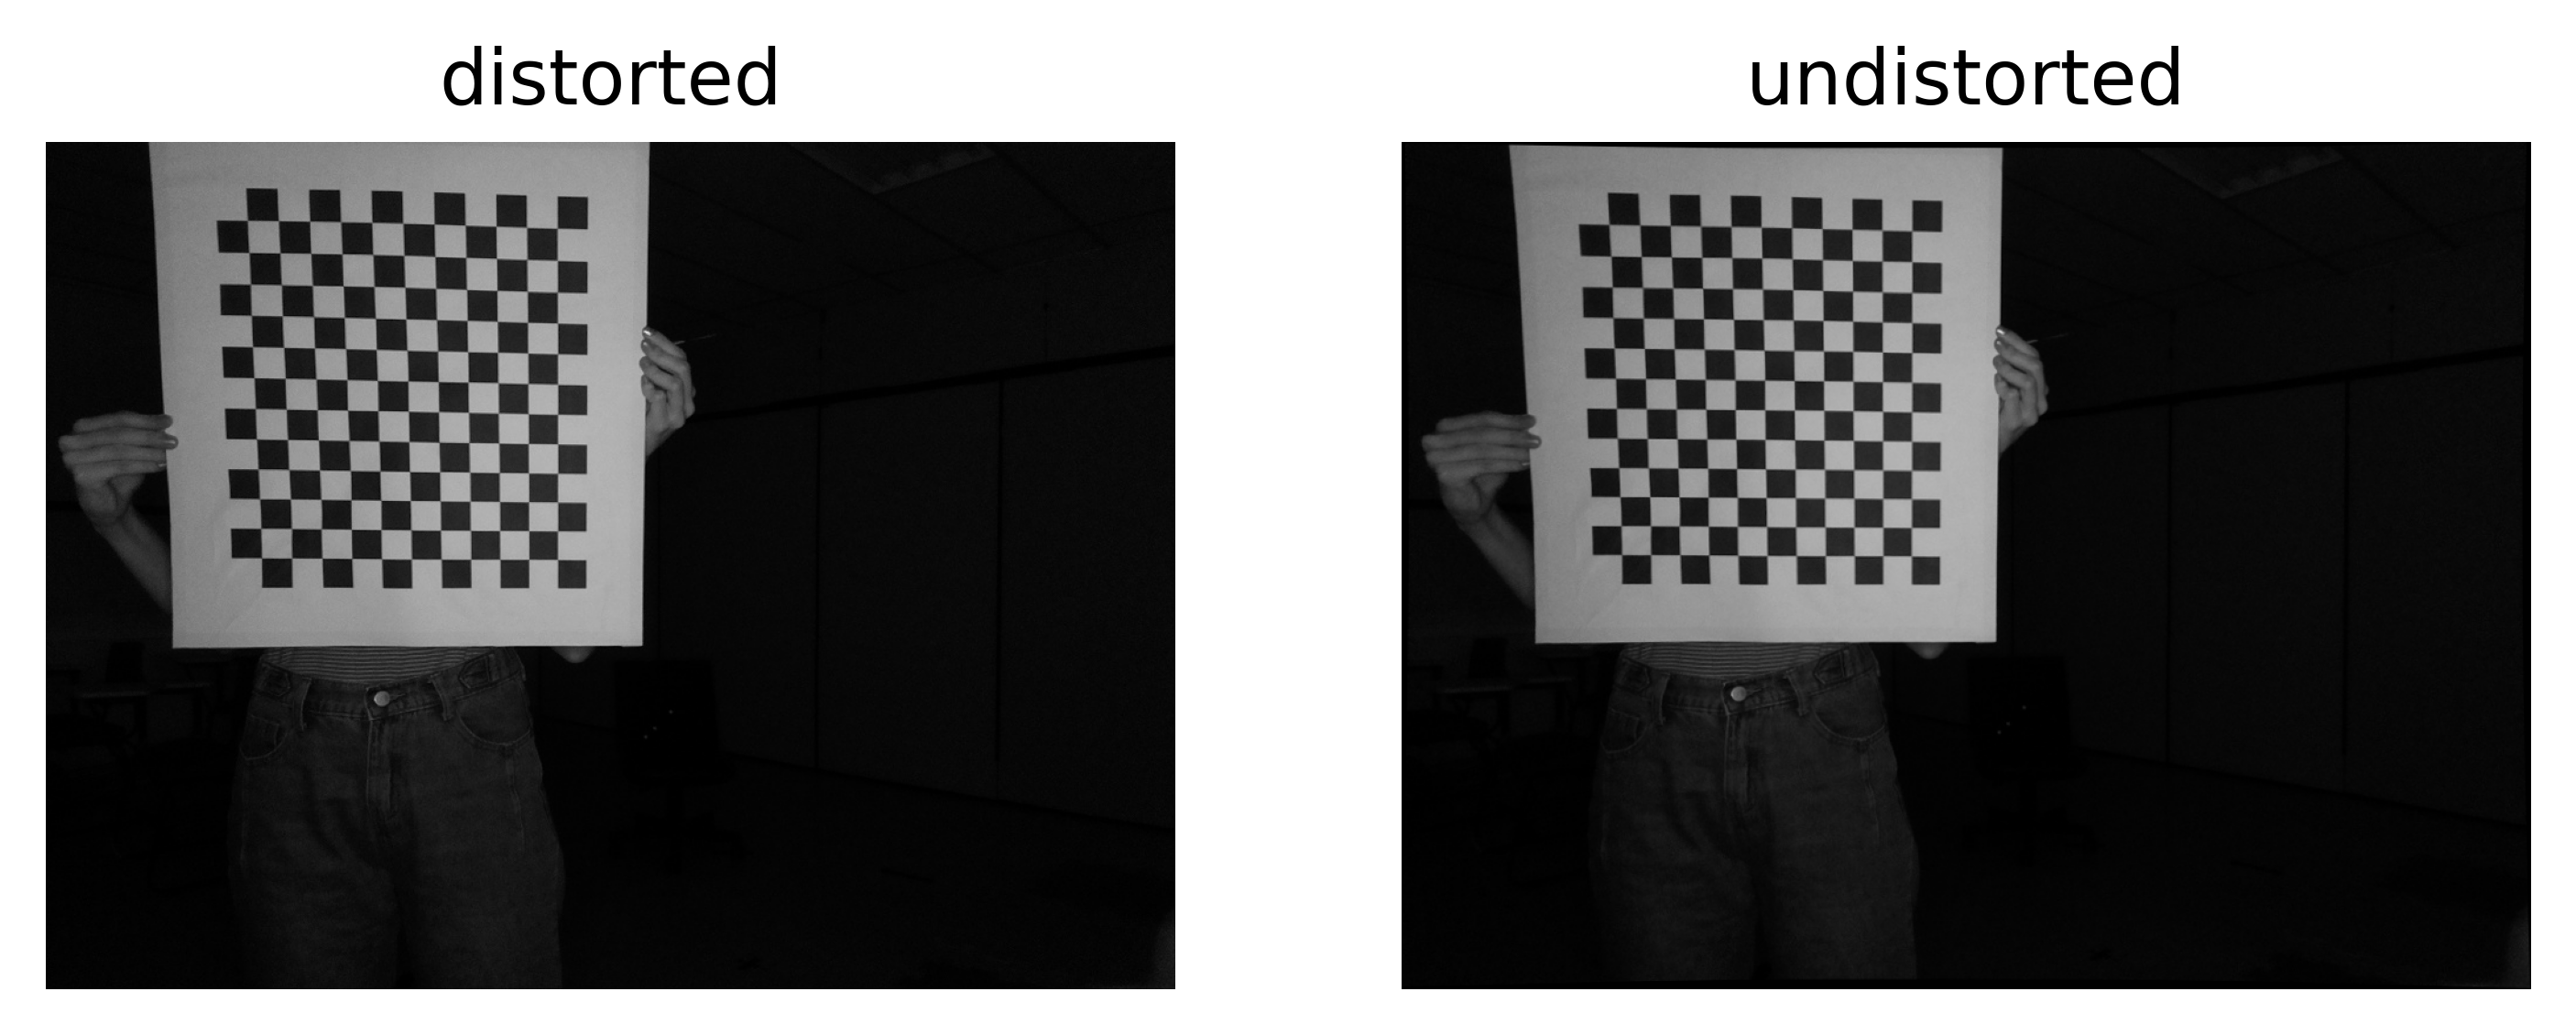

In [11]:
image = cv2.imread("padraoAntigo/padraoAntigo01.jpg")

newCameraMatrix, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, imgSize, 1, imgSize)
undistortedImage = cv2.undistort(image, cameraMatrix, distCoeffs, None, newCameraMatrix)

ig, axs = plt.subplots(1,2,figsize=(7, 4), dpi=500)
axs[0].imshow(image[:,:,::-1])
axs[0].axis('off')
axs[0].set_title('distorted')
axs[1].imshow(undistortedImage[:,:,::-1])
axs[1].axis('off')
axs[1].set_title('undistorted')